In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import nc_time_axis
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import zipfile
import palettable
import copy
import eofs

# get my own stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
## matplotlib RCparams setup

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.Petroff10().to_sn_palette()))
matplotlib.rcParams['font.family']='Helvetica Neue'
matplotlib.rcParams['legend.frameon']=False
plt.rcParams['pdf.fonttype'] = 42

In [3]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True, lon_ext=[-180,181], lat_ext=[-90,91]):
    if lon:
        ax.set_xticks(np.arange(*lon_ext,30), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(*lat_ext,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

### get meta & lsm for ExSamples, UKCP

In [4]:
## ExSamples data location:
ExS_dataloc = '../../ExSamples_product/20210622/'

## create a run_info dataframe
run_info = pd.DataFrame(data=[['05','10','15'],['2072','2068','2066'],['r001i1p01554','r001i1p02242','r001i1p02868'],['hot','wet','hot']],
                        index=['ensemble_member','year','run','type'],columns=['fut_2072','fut_2068','fut_2066']).T

run_info['label'] = ['HOT2','WET','HOT1']

## get land sea masks
ExS_GBR_lsm = xr.open_dataarray('../ancil/ExS_GBR_lsm.nc')
UKCP_GBR_lsm = xr.open_dataarray('../ancil/UKCP_GBR_lsm.nc',decode_times=False)
UKCP_glob_lsm = xr.open_dataarray('../ancil/UKCP_lsm.nc',decode_times=False).astype(bool)

## create a dict of UKCP PPE experiment subsamples
UKCP_experiment_list = {}
UKCP_experiment_list[10] = ['0000','1113','1554','1649','1843','1935','2123','2242','2491','2868']
UKCP_experiment_list[12] = ['0000','1113','1554','1649','1843','1935','2123','2242','2305','2335','2491','2868']
UKCP_experiment_list[15] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2305', '2335', '2491', '2832', '2868']
UKCP_experiment_list[13] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2491', '2832', '2868']
UKCP_experiment_list[20] = ['0000', '0090', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2089', '2123', '2242', '2305', '2335', '2491', '2753', '2832', '2868', '2884', '2914']

## create a colour palette if required.
choose_palette = [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]

## other options:
### IBM color blind
# [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]
### Petroff 6
# [matplotlib.colors.to_hex(get_palette.Petroff6().to_sn_palette()[i]) for i in [1,0,2]]
### tab10
# [matplotlib.colors.to_hex(get_palette.tab10().to_sn_palette()[i]) for i in [1,0,2]]

winter_colors = pd.Series(index=['1554','2242','2868'],data=choose_palette)

## Get data

UKCP mslp for each winter

In [5]:
def preproc_UKCP_psl(ds):
    # select area used for analogs
    ds = ds.squeeze().sel(latitude=slice(35,70),longitude=slice(-30,20)).expand_dims('ensemble_member_id')
    # average over DJF
    ds = ds.sel(time = ds['time.month'].isin([12,1,2])).resample(time='QS-DEC').mean()
    ds = ds.sel(time = ds['time.month']==12)
    # reassign ensemble member ids for easy slicing
    ds = ds.assign_coords(ensemble_member_id=[x[-4:].decode() for x in ds.ensemble_member_id.values.tolist()])
    return ds

UKCP_psl = xr.open_mfdataset(['/badc/ukcp18/data/land-gcm/global/60km/rcp85/'+"{:02d}".format(x)+'/psl/mon/latest/psl_rcp85_land-gcm_global_60km_'+"{:02d}".format(x)+'_mon_189912-209911.nc' for x in np.arange(1,16)],preprocess=preproc_UKCP_psl)

ExSamples mslp

In [6]:
def preproc_ExS_psl(ds):
    # rename coords to conventional
    ds=ds.squeeze().rename({'latitude4':'latitude','longitude4':'longitude','time1':'time','item16222_daily_mean':'psl'})
    # select area used for analogs
    ds=ds.sel(time=ds['time.month'].isin([12,1,2]),latitude=slice(71,34),longitude=slice(-31,21))
    # average over DJF
    ds=ds.resample(time='QS-DEC').mean()
    ds = ds.sel(time = ds['time.month']==12)
    # interpolate onto UKCP grid (which is very marginally different)
    ds=ds.interp(latitude=UKCP_psl.latitude,longitude=UKCP_psl.longitude)
    return ds.squeeze()

In [7]:
# only interested in baseline dataset
ExS_2868_base_psl = xr.concat([preproc_ExS_psl(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/NAtlanticEurope/psl_daily/*02868*.nc')],dim='ensemble_member_id').sortby('ensemble_member_id').psl/100
ExS_2242_base_psl = xr.concat([preproc_ExS_psl(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/NAtlanticEurope/psl_daily/*02242*.nc')],dim='ensemble_member_id').sortby('ensemble_member_id').psl/100
ExS_1554_base_psl = xr.concat([preproc_ExS_psl(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/NAtlanticEurope/psl_daily/*01554*.nc')],dim='ensemble_member_id').sortby('ensemble_member_id').psl/100

UKCP precip

In [8]:
## get UKCP precip
def preproc_UKCP_precip(ds):
    # selects DJF & averages over
    realization = str(ds.realization.values[()])
    ensemble_member_id = 'r00'+realization[0]+'i'+realization[1]+'p'+realization[2:]
    if not ensemble_member_id[-4:] in UKCP_experiment_list[15]:
        return None
    ds = ds.expand_dims('realization').rename(dict(realization='ensemble_member_id',precipitation_flux='pr')).assign_coords(ensemble_member_id=[ensemble_member_id])
    return ds

UKCP_precip_scaling = 1000/997*(3600*24) # convert to mm -> per day

UKCP_pr = xr.concat([x.chunk({'ensemble_member_id':1}) for x in [preproc_UKCP_precip(xr.open_dataset(x)) for x in sorted(glob.glob('/home/users/njleach/UKCP_hadgem3_data/pr/*.nc'))] if x is not None],'ensemble_member_id')*UKCP_precip_scaling

In [9]:
# convert to seasonal mean timeseries
UKCP_prm = UKCP_pr.resample(time='QS-DEC').mean()
UKCP_prm = UKCP_prm.sel(time=UKCP_prm['time.month']==12)

/home/users/njleach/miniconda3/lib/python3.9/site-packages/dask/array/core.py:4337: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


In [10]:
## average over UK land:
UKCP_GBR_lsm_slice = UKCP_GBR_lsm.sel(latitude=slice(50,61),longitude=slice(-12,2)).assign_coords(latitude=UKCP_prm.latitude,longitude=UKCP_prm.longitude)

UKCP_prm_df = UKCP_prm.pr.where(UKCP_GBR_lsm_slice).weighted(np.cos(np.deg2rad(UKCP_GBR_lsm_slice.latitude))).mean(['latitude','longitude']).to_pandas()
# set columns equal to 4-digit member code
UKCP_prm_df.columns = [x[-4:] for x in UKCP_prm_df.columns]
# set index equal to years (ie. the JF year)
UKCP_prm_df.index = np.arange(1900,2100)

ExSamples precip

In [11]:
ExS_GBR_lsm_slice = ExS_GBR_lsm.sel(latitude=slice(62,48),longitude=slice(-13,5))

In [12]:
def preproc_ExS_pr(ds):
    # squeeze out unwanted dimensions
    ds = ds.squeeze()
    # rename default output names to conventional ones
    ds = ds.rename({'latitude2':'latitude','longitude2':'longitude','time1':'time','item5216_6hrly_mean':'pr'})
    # select DJF only
    ds = ds.sel(time=ds['time.month'].isin([12,1,2]))
    # ensure spatial coords match the lsm exactly
    ds = ds.assign_coords(latitude=ExS_GBR_lsm_slice.latitude,longitude=ExS_GBR_lsm_slice.longitude) 
    
    ## check for excessive values + print those members:
    if ds.ensemble_member_id.sel(ensemble_member_id=(UKCP_precip_scaling*ds.pr.mean(['latitude','longitude'])>100).any('time')).values.size:
        print(ds.ensemble_member_id.sel(ensemble_member_id=(UKCP_precip_scaling*ds.pr.mean(['latitude','longitude'])>100).any('time')).values[0])
    
    return ds

def preproc_ExS_meanpr(ds):
    ds = preproc_ExS_pr(ds).pr    
    # take time mean at each gridpoint
    ds = ds.mean('time')
    # average over UK land
    ds = ds.where(ExS_GBR_lsm_slice).weighted(np.cos(np.deg2rad(ExS_GBR_lsm_slice.latitude))).mean(['latitude','longitude'])
    return ds.to_pandas() * UKCP_precip_scaling
    
ExS_1554_base_prm = pd.concat([preproc_ExS_meanpr(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/pr_daily/*1554*.nc')],axis=0)
ExS_2242_base_prm = pd.concat([preproc_ExS_meanpr(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/pr_daily/*2242*.nc')],axis=0)
ExS_2868_base_prm = pd.concat([preproc_ExS_meanpr(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/pr_daily/*2868*.nc')],axis=0)

## EOF analysis of psl

In [13]:
UKCP_psl_eofdata = (UKCP_psl.sel(time=slice('1996','2025')) - UKCP_psl.sel(time=slice('1996','2025')).mean('time')).stack(eofindex=['time','ensemble_member_id']).psl.transpose('eofindex','latitude','longitude')

In [14]:
coslat = np.cos(np.deg2rad(UKCP_psl_eofdata.latitude.values)).clip(0., 1.)
wgts = np.sqrt(coslat)[:,None]
solver = eofs.standard.Eof(UKCP_psl_eofdata.values,weights=wgts)

In [15]:
eofs_to_retain=20
UKCP_eofs = xr.DataArray(solver.eofs(eofscaling=0,neofs=eofs_to_retain),dims=['eof','latitude','longitude'],coords=dict(eof=np.arange(eofs_to_retain),latitude=UKCP_psl_eofdata.latitude.values,longitude=UKCP_psl_eofdata.longitude.values))
UKCP_pcs = xr.DataArray(solver.pcs(pcscaling=0,npcs=eofs_to_retain),dims=['eofindex','eof'],coords=dict(eofindex=UKCP_psl_eofdata.eofindex,eof=np.arange(eofs_to_retain)))
print('Variance explained in increasing PC order:')
print(*solver.varianceFraction(neigs=eofs_to_retain))

Variance explained in increasing PC order:
0.43339673 0.33463472 0.12514731 0.05386939 0.022964546 0.010616219 0.005708733 0.0036290004 0.0031298387 0.0012515159 0.0008228622 0.0007542787 0.00068220205 0.0004940272 0.0003801975 0.0003212013 0.000250767 0.00020061598 0.00017091807 0.00014261012


/home/users/njleach/miniconda3/lib/python3.9/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

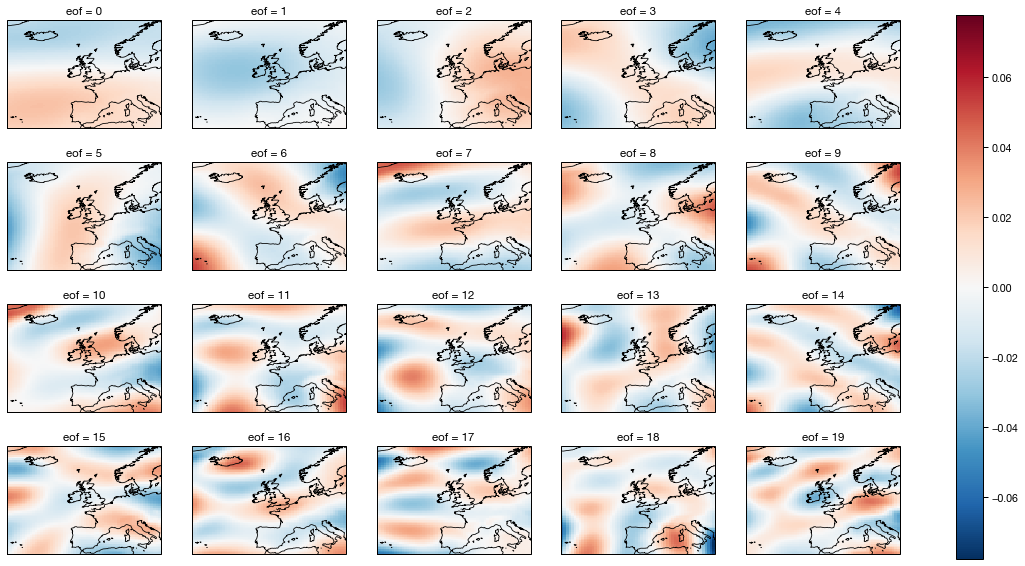

In [16]:
p=UKCP_eofs.plot(col='eof',col_wrap=5,subplot_kws=dict(projection=crs.PlateCarree()),figsize=(20,10))

[a.coastlines() for a in p.axes.flatten()]
[a.set_xlim(-30,20) for a in p.axes.flatten()]
[a.set_ylim(35,70) for a in p.axes.flatten()]
''

### how important is each EOF for precipitation prediction?

In [17]:
UKCP_pcs_normalised = pd.DataFrame(index=UKCP_psl_eofdata.eofindex.values,columns=np.arange(eofs_to_retain),data=solver.pcs(pcscaling=1,npcs=eofs_to_retain))

In [18]:
X = (UKCP_prm_df.loc[1997:2026]-UKCP_prm_df.loc[1997:2026].mean()).stack().values

Y = UKCP_pcs_normalised.values

cross validation to select the important EOFs

In [19]:
olse = OLSE.multiple(X[:,None])
R2_excl = []

for eof in np.arange(Y.shape[1]):
    y = np.delete(Y,eof,axis=1)
    olse.fit(y)
    R2_excl += [olse.R2()]

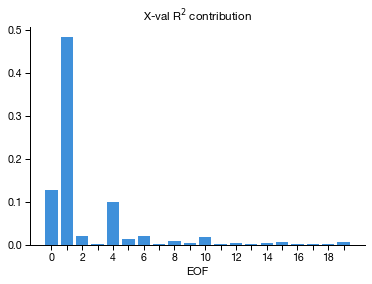

In [20]:
# get R2 for all features
olse.fit(Y)

plt.bar(np.arange(eofs_to_retain),olse.R2()-np.array(R2_excl).flatten())
plt.title('X-val R$^2$ contribution')
plt.xlabel('EOF')
plt.xticks(np.arange(0,20,1),labels='/'.join([str(x)+'/ ' for x in np.arange(0,20,2)]).split('/'))
sn.despine()

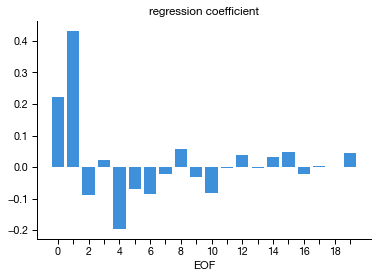

In [21]:
# get regrssion coefficients for all features
olse.fit(Y)

plt.bar(np.arange(eofs_to_retain),olse.B.flatten())
plt.title('regression coefficient')
plt.xlabel('EOF')
plt.xticks(np.arange(0,20,1),labels='/'.join([str(x)+'/ ' for x in np.arange(0,20,2)]).split('/'))
sn.despine()

From this, it looks like **the most important EOFs to retain are 0, 1 & 4.**

In [22]:
# variance explained by those three:
y = Y[:,[0,1,4]]
olse.fit(y)

print('Fraction of variance explained by EOFs 0, 1, 4:',olse.R2()[0])

Fraction of variance explained by EOFs 0, 1, 4: 0.7074075


#### Plotting selected EOFs

''

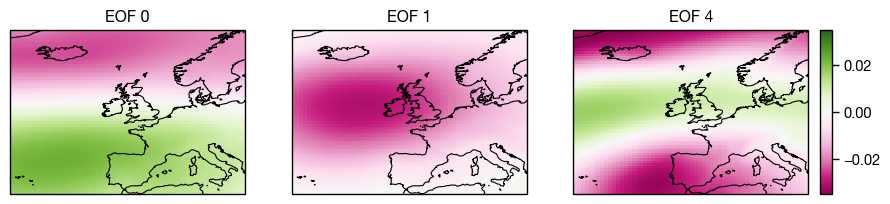

In [23]:
fig,ax = plt.subplots(1,3,figsize=(10.3,7/3),subplot_kw=dict(projection=crs.PlateCarree()))

[UKCP_eofs.sel(eof=x).plot(ax=ax[i],add_colorbar=False,vmin=-0.035,vmax=0.035,cmap='PiYG') for i,x in enumerate([0,1,4])]

axins = inset_axes(ax[-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.05, 0, 1, 1),bbox_transform=ax[-1].transAxes,borderpad=0)
cbar = plt.colorbar(ax[-1].collections[0],cax=axins,orientation='vertical')
# cbar.set_label('sea ice fraction / %',labelpad=8)

[a.coastlines() for a in ax]
[a.set_xlim(-30,20) for a in ax]
[a.set_ylim(35,70) for a in ax]
[ax[i].set_title('EOF '+str(x)) for i,x in enumerate([0,1,4])]

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS1.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

### Projecting the EOFs onto ExSamples

In [24]:
## create lists of members for easy slicing later:
ExS_members = {'1554':ExS_1554_base_psl.ensemble_member_id.values,'2242':ExS_2242_base_psl.ensemble_member_id.values,'2868':ExS_2868_base_psl.ensemble_member_id.values}

In [25]:
ExS_all_base_psl = xr.concat([ExS_1554_base_psl-ExS_1554_base_psl.mean('ensemble_member_id'),
                              ExS_2242_base_psl-ExS_2242_base_psl.mean('ensemble_member_id'),
                              ExS_2868_base_psl-ExS_2868_base_psl.mean('ensemble_member_id')],dim='ensemble_member_id')

In [26]:
ExS_baseline_psl_ppcs = xr.DataArray(solver.projectField(ExS_all_base_psl.values,neofs=eofs_to_retain),dims=['ensemble_member_id','eof'],coords=dict(ensemble_member_id=ExS_all_base_psl.ensemble_member_id,eof=np.arange(eofs_to_retain)))

In [27]:
# ExS_baseline_psl_ppcs.sel(eof=[0,1,4]).to_pandas()

How do the PC distributions compare between UKCP & ExSamples?

''

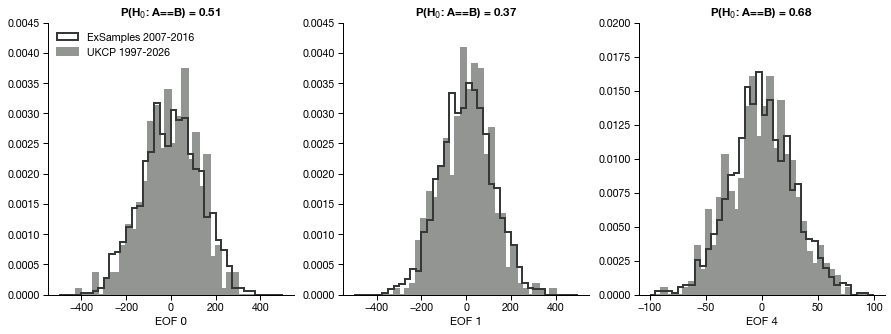

In [28]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

bins=[np.arange(-500,501,25),np.arange(-500,501,25),np.arange(-100,101,5)]
ylims=[(0,0.0045),(0,0.0045),(0,0.02)]

for i,x in enumerate([0,1,4]):
    
    ax[i].hist(x=ExS_baseline_psl_ppcs.sel(eof=x).values,histtype='step',bins=bins[i],lw=2,density=True,color='xkcd:dark grey',label='ExSamples 2007-2016',zorder=5)
    ax[i].hist(x=UKCP_pcs.sel(eof=x).values,histtype='step',bins=bins[i],lw=2,density=True,color='xkcd:grey',fill=True,label='UKCP 1997-2026')
    
    ax[i].set_title('P(H$_0$: A==B) = '+str(round(sp.stats.ks_2samp(UKCP_pcs.sel(eof=x).values,ExS_baseline_psl_ppcs.sel(eof=x).values).pvalue,2)),fontweight='bold')
    
    ax[i].set_ylim(*ylims[i])
#     ax[i].set_yticks([])
#     ax[i].set_xticks([])
    ax[i].set_xlabel('EOF '+str(x))
    
ax[0].legend(frameon=False,loc=2)
sn.despine()

[fig.savefig('../output/figs/SI/FIGS2.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''